In [1]:
# !pip install pandas numpy openpyxl scikit-learn tensorflow


In [2]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
df_master = pd.read_excel("master.xlsx")
# Filter out rows that have no TTF price
df_master = df_master[~df_master["TTF_Daily_Price"].isna()].copy()


In [4]:
df_master.ffill(inplace=True)
df_master.bfill(inplace=True)
print(df_master.isna().sum())


Date                         0
TTF_Daily_Price              0
Summer_Winter_Spread         0
NL_Storage_%Full             0
EURUSD                       0
Brent_USD_per_barrel         0
Open Interest_x              0
SMAVG (15)_x                 0
Coal_USD_per_tonne           0
Open Interest_y              0
SMAVG (15)_y                 0
EUA_Euros_per_tonne          0
Open Interest                0
SMAVG (15)                   0
NL_LNG_Import_tonne          0
UK_Interconnector_MCM_d      0
TTF_Mon_Index                0
Exchange rate in euro/mwh    0
UK_NL_Spread                 0
Daily_Temperature            0
dtype: int64


In [5]:
df_master.to_excel("master_noNA.xlsx", index=False)

In [6]:
feature_cols = [
    "Summer_Winter_Spread",
    "NL_Storage_%Full",
    "EURUSD",
    "Brent_USD_per_barrel",
    # "Open Interest_x",
    # "SMAVG (15)_x",
    "Coal_USD_per_tonne",
    # "Open Interest_y",
    # "SMAVG (15)_y",
    "EUA_Euros_per_tonne",
    # "Open Interest",
    # "SMAVG (15)",
    "NL_LNG_Import_tonne",
    "UK_Interconnector_MCM_d",
    "TTF_Mon_Index",
    "Exchange rate in euro/mwh",
    "UK_NL_Spread",
    "Daily_Temperature"
]

df_model = df_master[["Date", "TTF_Daily_Price"] + feature_cols].copy()
df_model.dropna(inplace=True)

In [7]:
# Scale
data_for_scaling = df_model.drop("Date", axis=1).values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_for_scaling)

scaled_df = pd.DataFrame(
    scaled_data,
    columns=df_model.columns.drop("Date"),
    index=df_model.index
)
scaled_df["Date"] = df_model["Date"].values

scaled_df.head()

,TTF_Daily_Price,Summer_Winter_Spread,NL_Storage_%Full,EURUSD,Brent_USD_per_barrel,Coal_USD_per_tonne,EUA_Euros_per_tonne,NL_LNG_Import_tonne,UK_Interconnector_MCM_d,TTF_Mon_Index,Exchange rate in euro/mwh,UK_NL_Spread,Daily_Temperature,Date
0,0.018358,0.173476,0.492937,0.459529,0.338158,0.029727,0.108701,0.255519,0.088813,0.017324,0.926160,0.730938,0.342070,2020-02-14
3,0.019104,0.173476,0.488797,0.459897,0.340514,0.028971,0.117860,0.484263,0.246323,0.019113,0.902250,0.728809,0.375342,2020-02-17
4,0.019940,0.173581,0.485265,0.449595,0.340626,0.022421,0.118944,0.486906,0.246323,0.018463,0.919128,0.729583,0.321653,2020-02-18
5,0.019776,0.173476,0.479420,0.445180,0.351172,0.021791,0.125813,0.255519,0.275917,0.019536,0.872714,0.728305,0.311203,2020-02-19
6,0.020239,0.173476,0.474184,0.445548,0.350275,0.020028,0.124970,0.255519,0.246323,0.019439,0.845288,0.728421,0.337580,2020-02-20


In [8]:
# Create sequences
def create_sequences(dataframe, target_col="TTF_Daily_Price", n_lag=30):
    arr = dataframe.drop("Date", axis=1).values
    dates = dataframe["Date"].values

    target_idx = list(dataframe.drop("Date", axis=1).columns).index(target_col)
    X, y, X_dates = [], [], []

    for i in range(n_lag, len(arr)):
        seq_x = arr[i - n_lag : i, :]
        seq_y = arr[i, target_idx]
        X.append(seq_x)
        y.append(seq_y)
        X_dates.append(dates[i])

    return np.array(X), np.array(y), np.array(X_dates)

n_lag = 30
X_all, y_all, dates_all = create_sequences(
    scaled_df,
    target_col="TTF_Daily_Price",
    n_lag=n_lag
)
print("Shapes => ", X_all.shape, y_all.shape, dates_all.shape)

train_size = int(0.8 * len(X_all))

X_train = X_all[:train_size]
y_train = y_all[:train_size]

X_test = X_all[train_size:]
y_test = y_all[train_size:]
dates_test = dates_all[train_size:]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes :", X_test.shape, y_test.shape)


Shapes =>  (1271, 30, 13) (1271,) (1271,)
Train shapes: (1016, 30, 13) (1016,)
Test shapes : (255, 30, 13) (255,)


In [9]:
model = Sequential()
# First LSTM layer (return_sequences=True so we can stack another LSTM)
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

# Second LSTM layer
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

# # Dense layer for more representational power
# model.add(Dense(32, activation='relu'))

# Final output layer
model.add(Dense(1))

model.compile(optimizer=Adam(0.001), loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=4,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.0054 - val_loss: 5.6717e-04
Epoch 2/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0035 - val_loss: 9.3223e-04
Epoch 3/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0046 - val_loss: 8.1677e-04
Epoch 4/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0052 - val_loss: 6.6477e-04
Epoch 5/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0052 - val_loss: 0.0010
Epoch 6/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0046 - val_loss: 0.0013
Epoch 7/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 9/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 10/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 11/50
229/229 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 12/50
229/229 ━━━━━━━━━━━━━

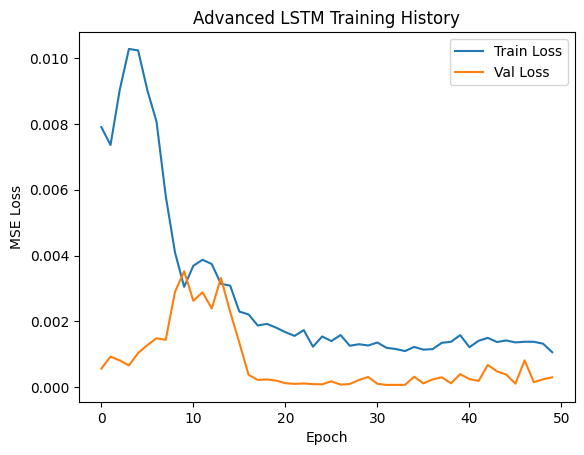

In [11]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Advanced LSTM Training History")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

In [12]:
y_pred_scaled = model.predict(X_test)

# Reconstruct array for all features (to invert only the target)
num_features = scaled_df.drop("Date", axis=1).shape[1]
target_idx = list(scaled_df.drop("Date", axis=1).columns).index("TTF_Daily_Price")

pred_test_all_features = np.zeros((len(y_pred_scaled), num_features))
pred_test_all_features[:, target_idx] = y_pred_scaled.ravel()
inv_pred = scaler.inverse_transform(pred_test_all_features)
y_pred_unscaled_lstm = inv_pred[:, target_idx]

# Also invert y_test
test_all_features = np.zeros((len(y_test), num_features))
test_all_features[:, target_idx] = y_test
inv_y_test = scaler.inverse_transform(test_all_features)
y_true_unscaled = inv_y_test[:, target_idx]


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [13]:
mse = np.mean((y_pred_unscaled_lstm - y_true_unscaled) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_pred_unscaled_lstm - y_true_unscaled))

print("Test MSE :", mse)
print("Test RMSE:", rmse)
print("Test MAE :", mae)


Test MSE : 34.6784037620042
Test RMSE: 5.888837216463383
Test MAE : 4.984121496722746


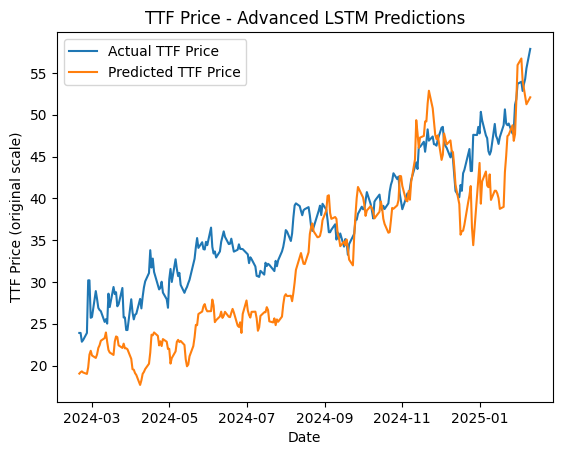

In [14]:
plt.plot(dates_test, y_true_unscaled, label="Actual TTF Price")
plt.plot(dates_test, y_pred_unscaled_lstm, label="Predicted TTF Price")
plt.legend()
plt.title("TTF Price - Advanced LSTM Predictions")
plt.xlabel("Date")
plt.ylabel("TTF Price (original scale)")
plt.show()


In [15]:
#print out predicted price
print("Predicted TTF Price:", y_pred_unscaled_lstm)

Predicted TTF Price: [19.03800088 19.20394126 19.30505696 19.16731577 18.99844016 19.77579209
 21.31038862 21.76492009 21.20181504 20.90984444 21.32776539 22.10120368
 22.43591483 22.96629804 23.28667748 23.95957413 22.82994959 21.86716396
 21.55993815 21.26996431 22.86932561 23.48264906 23.39913476 22.41551298
 22.11075816 22.62023035 22.05827343 22.06456321 21.9438843  20.7997034
 19.56119078 19.50180727 19.09205805 18.86877584 17.68227372 18.22490203
 19.0024187  19.23585939 19.57850266 20.21811838 21.55583981 23.68718672
 23.62131874 23.95703326 23.55114776 22.40745108 22.90046501 22.33090545
 23.16440615 22.85139973 21.97892237 22.00410146 20.23401256 20.89409503
 21.69535312 22.83921453 23.0723657  22.80641782 22.94126871 22.45976608
 20.76100129 19.91211559 20.11862504 21.10652487 22.33074072 23.39582513
 24.86772853 24.82870194 26.16334337 26.4594772  27.09052186 27.3474469
 26.77658945 26.48997764 26.5062512  27.88979816 27.18329112 25.19199665
 25.42647566 25.87350681 26.4451

In [16]:
import numpy as np

def permutation_importance_lstm(model, X_test, y_test, baseline_mse, feature_names, scaler, target_idx):
    """
    model         : your trained LSTM model
    X_test        : shape (samples, time_lag, num_features)
    y_test        : scaled target of shape (samples,)
    baseline_mse  : the original MSE on the test set (no shuffling)
    feature_names : list of feature names in the same order as X_test's last dimension
    scaler        : the MinMaxScaler (or StandardScaler) used to invert predictions
    target_idx    : index of the target column in the scaled data (for inverse_transform)

    Returns: A sorted list of (feature_name, importance) based on MSE difference
    """
    importances = []

    # Number of features
    n_features = len(feature_names)

    for f_idx in range(n_features):
        # 1) Copy X_test
        X_test_permuted = X_test.copy()

        # 2) Shuffle the feature f_idx across the entire test set
        #    We shuffle "in place" across the sample dimension, for all timesteps
        original_col = X_test_permuted[:, :, f_idx].ravel()
        shuffled_col = np.random.permutation(original_col)
        X_test_permuted[:, :, f_idx] = shuffled_col.reshape(X_test_permuted[:, :, f_idx].shape)

        # 3) Re-predict with the shuffled data
        y_pred_scaled = model.predict(X_test_permuted)

        # 4) Invert scaling for y_pred and y_test
        # Reconstruct an array for all scaled features, but only fill the target col
        pred_test_all_features = np.zeros((len(y_pred_scaled), scaler.n_features_in_))
        pred_test_all_features[:, target_idx] = y_pred_scaled.ravel()
        inv_pred = scaler.inverse_transform(pred_test_all_features)
        y_pred_unscaled = inv_pred[:, target_idx]

        # Similarly for y_test
        test_all_features = np.zeros((len(y_test), scaler.n_features_in_))
        test_all_features[:, target_idx] = y_test
        inv_y_test = scaler.inverse_transform(test_all_features)
        y_true_unscaled = inv_y_test[:, target_idx]

        # 5) Compute MSE
        mse_permuted = np.mean((y_pred_unscaled - y_true_unscaled) ** 2)

        # 6) Importance is how much MSE worsens
        importance = mse_permuted - baseline_mse
        importances.append((feature_names[f_idx], importance))

    # Sort by importance descending (i.e. larger difference => more important)
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances


In [17]:
# Baseline predictions
y_pred_scaled = model.predict(X_test)

# Invert
pred_test_all = np.zeros((len(y_pred_scaled), scaler.n_features_in_))
pred_test_all[:, target_idx] = y_pred_scaled.ravel()
inv_pred = scaler.inverse_transform(pred_test_all)
y_pred_unscaled = inv_pred[:, target_idx]

test_all = np.zeros((len(y_test), scaler.n_features_in_))
test_all[:, target_idx] = y_test
inv_y_test = scaler.inverse_transform(test_all)
y_true_unscaled = inv_y_test[:, target_idx]

baseline_mse = np.mean((y_true_unscaled - y_pred_unscaled)**2)
print("Baseline MSE:", baseline_mse)


feature_names = [
    "Summer_Winter_Spread",
    "NL_Storage_%Full",
    "NL_Industrial_Demand_GWh_d",
    "EURUSD",
    "Brent_USD_per_barrel",
    "Coal_USD_per_tonne",
    "EUA_Euros_per_tonne",
    "NL_LNG_Import_tonne",
    "UK_Interconnector_MCM_d",
    "UK_NL_Spread",
    "Daily_Temperature"
]

feature_columns = scaled_df.drop("Date", axis=1).columns
target_idx = list(feature_columns).index("TTF_Daily_Price")

importances = permutation_importance_lstm(
    model=model,
    X_test=X_test,
    y_test=y_test,
    baseline_mse=baseline_mse,
    feature_names=feature_names,
    scaler=scaler,
    target_idx=target_idx
)

print("Permutation importance (feature -> MSE difference):")
for feat, diff_mse in importances:
    print(f"{feat:40s}  {diff_mse:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Baseline MSE: 34.6784037620042
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Permutation importance (feature -> MSE difference):
NL_Storage_%Full                          39.2281
EUA_Euros_per_tonne                       6.6691
EURUSD                                    6.4904
Summer_Winter_Spread                      5.1579
UK_Interconnector_MCM_d                   3.5796
Brent_USD_per_barrel                      2.9804
NL_LNG_Import_tonne                       1.7691
UK_NL_Spread                              1.5201
Coal_USD_per_tonne                        -0.3239
NL_Industrial_Dema

In [18]:
pred_df = pd.DataFrame({
    "Date": dates_test,
    "lstm_predicted": y_pred_unscaled
})

df_master_with_pred = df_master.merge(pred_df, on="Date", how="left")

df_master_with_pred.to_excel("master_with_predictions.xlsx", index=False)



In [19]:
pred_df

,Date,lstm_predicted
0,2024-02-20,19.038001
1,2024-02-21,19.203941
2,2024-02-22,19.305057
3,2024-02-23,19.167316
4,2024-02-26,18.998440
...,...,...
250,2025-02-04,54.083453
251,2025-02-05,53.163363
252,2025-02-06,52.230224
253,2025-02-07,51.254245


In [20]:
# !pip install xgboost
from xgboost import XGBRegressor

In [21]:
df_model = df_master[["Date", "TTF_Daily_Price"] + feature_cols].copy()
df_model.dropna(inplace=True)

# Scale
data_for_scaling = df_model.drop("Date", axis=1).values
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_for_scaling)

scaled_df = pd.DataFrame(
    scaled_data,
    columns=df_model.columns.drop("Date"),
    index=df_model.index
)
scaled_df["Date"] = df_model["Date"].values


In [22]:
def create_sequences(dataframe, target_col="TTF_Daily_Price", n_lag=30):
    arr = dataframe.drop("Date", axis=1).values
    dates = dataframe["Date"].values

    target_idx = list(dataframe.drop("Date", axis=1).columns).index(target_col)
    X, y, X_dates = [], [], []

    for i in range(n_lag, len(arr)):
        seq_x = arr[i - n_lag : i, :]  # shape (n_lag, num_features)
        seq_y = arr[i, target_idx]     # single float
        X.append(seq_x)
        y.append(seq_y)
        X_dates.append(dates[i])

    return np.array(X), np.array(y), np.array(X_dates)

n_lag = 30
X_all_seq, y_all, dates_all = create_sequences(
    scaled_df, target_col="TTF_Daily_Price", n_lag=n_lag
)


In [23]:
# Flatten sequence dimension
num_samples, seq_len, num_features = X_all_seq.shape
X_all_flat = X_all_seq.reshape(num_samples, seq_len * num_features)  # shape (num_samples, 30*num_features)

print("X_all_flat:", X_all_flat.shape)
print("y_all:", y_all.shape)


X_all_flat: (1271, 390)
y_all: (1271,)


In [24]:
train_size = int(0.8 * len(X_all_flat))

X_train_flat = X_all_flat[:train_size]
y_train = y_all[:train_size]

X_test_flat = X_all_flat[train_size:]
y_test = y_all[train_size:]
dates_test = dates_all[train_size:]

print("Train shapes:", X_train_flat.shape, y_train.shape)
print("Test shapes :", X_test_flat.shape, y_test.shape)


Train shapes: (1016, 390) (1016,)
Test shapes : (255, 390) (255,)


In [25]:
# pip install --upgrade xgboost


In [26]:
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_flat, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [27]:
y_pred_scaled = xgb_model.predict(X_test_flat)  # predictions in scaled space


In [28]:
num_total_features = scaled_df.drop("Date", axis=1).shape[1]
target_idx = list(scaled_df.drop("Date", axis=1).columns).index("TTF_Daily_Price")

# Prepare arrays to invert predictions
pred_test_all_features = np.zeros((len(y_pred_scaled), num_total_features))
pred_test_all_features[:, target_idx] = y_pred_scaled
inv_pred = scaler.inverse_transform(pred_test_all_features)
y_pred_unscaled = inv_pred[:, target_idx]

test_all_features = np.zeros((len(y_test), num_total_features))
test_all_features[:, target_idx] = y_test
inv_y_test = scaler.inverse_transform(test_all_features)
y_true_unscaled = inv_y_test[:, target_idx]


In [29]:
mse_xgb = mean_squared_error(y_true_unscaled, y_pred_unscaled)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_true_unscaled, y_pred_unscaled)

print("XGBoost Test MSE :", mse_xgb)
print("XGBoost Test RMSE:", rmse_xgb)
print("XGBoost Test MAE :", mae_xgb)


XGBoost Test MSE : 8.442646083625819
XGBoost Test RMSE: 2.9056231833508313
XGBoost Test MAE : 2.0414749972948845


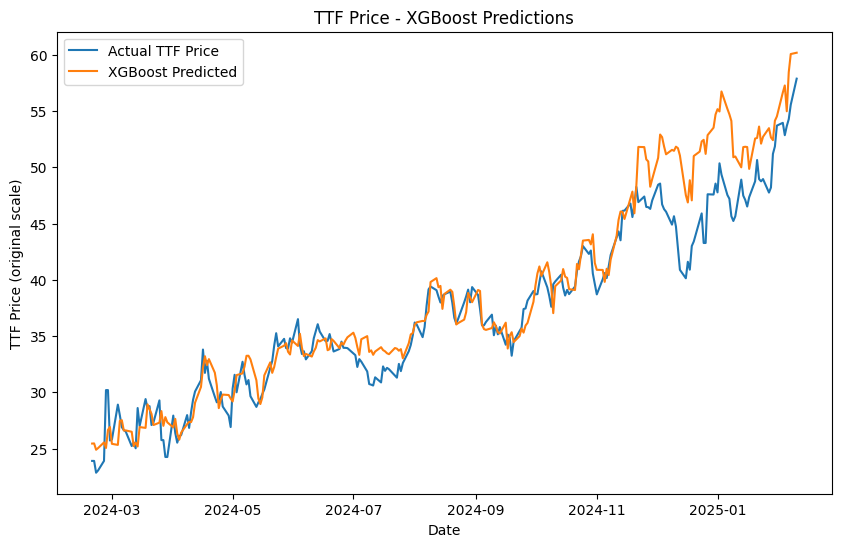

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(dates_test, y_true_unscaled, label="Actual TTF Price")
plt.plot(dates_test, y_pred_unscaled, label="XGBoost Predicted")
plt.title("TTF Price - XGBoost Predictions")
plt.xlabel("Date")
plt.ylabel("TTF Price (original scale)")
plt.legend()
plt.show()


In [31]:
df_master = pd.read_excel("master_with_predictions.xlsx")


pred_df_xgb = pd.DataFrame({
    "Date": dates_test,
    "xgb_predicted": y_pred_unscaled
})

df_master_with_both = df_master.merge(pred_df_xgb, on="Date", how="left")

df_master_with_both.to_excel("master_with_lstm_and_xgb_preds.xlsx", index=False)

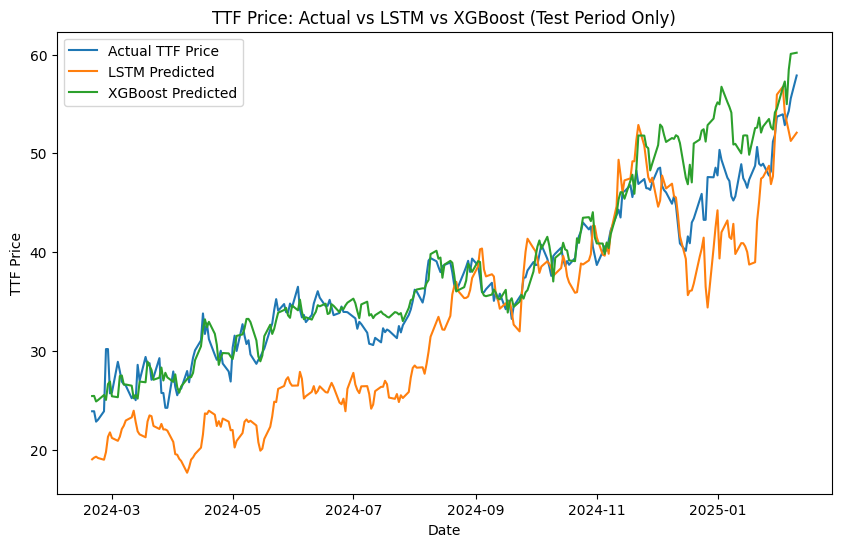

In [32]:
import matplotlib.pyplot as plt

df_test_period = df_master_with_both.dropna(subset=["lstm_predicted", "xgb_predicted"])

plt.figure(figsize=(10, 6))
plt.plot(df_test_period["Date"], df_test_period["TTF_Daily_Price"], label="Actual TTF Price")
plt.plot(df_test_period["Date"], df_test_period["lstm_predicted"], label="LSTM Predicted")
plt.plot(df_test_period["Date"], df_test_period["xgb_predicted"], label="XGBoost Predicted")

plt.title("TTF Price: Actual vs LSTM vs XGBoost (Test Period Only)")
plt.xlabel("Date")
plt.ylabel("TTF Price")
plt.legend()
plt.show()


In [34]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint


# Calculate Pearson correlation (r) for TTF vs. Brent
corr_ttf_brent = df_master["TTF_Daily_Price"].corr(df_master["Brent_USD_per_barrel"], method='pearson')

# TTF vs. Carbon (EUA)
corr_ttf_eua = df_master["TTF_Daily_Price"].corr(df_master["EUA_Euros_per_tonne"], method='pearson')

print(f"Pearson Correlation (TTF vs Brent): {corr_ttf_brent:.4f}")
print(f"Pearson Correlation (TTF vs EUA)  : {corr_ttf_eua:.4f}")

# COINTEGRATION TEST (Engle-Granger)
# The 'coint' function returns: (test_statistic, p_value, critical_values)
# If p_value < 0.05, we generally say the series are cointegrated at the 5% level.

# A) TTF vs. Brent
coint_ttf_brent, p_value_ttf_brent, crit_values_brent = coint(
    df_master["TTF_Daily_Price"], df_master["Brent_USD_per_barrel"]
)

# B) TTF vs. EUA
coint_ttf_eua, p_value_ttf_eua, crit_values_eua = coint(
    df_master["TTF_Daily_Price"], df_master["EUA_Euros_per_tonne"]
)

print("\nCOINTEGRATION TEST (Engle-Granger)")
print("-----------------------------------")
print("TTF vs Brent:")
print(f"  Test Statistic: {coint_ttf_brent:.4f}")
print(f"  p-value       : {p_value_ttf_brent:.4f}")
print(f"  Critical vals : {crit_values_brent}")

print("\nTTF vs EUA:")
print(f"  Test Statistic: {coint_ttf_eua:.4f}")
print(f"  p-value       : {p_value_ttf_eua:.4f}")
print(f"  Critical vals : {crit_values_eua}")


Pearson Correlation (TTF vs Brent): 0.6251
Pearson Correlation (TTF vs EUA)  : 0.5326

COINTEGRATION TEST (Engle-Granger)
-----------------------------------
TTF vs Brent:
  Test Statistic: -3.7145
  p-value       : 0.0176
  Critical vals : [-3.90488438 -3.34083411 -3.04771407]

TTF vs EUA:
  Test Statistic: -2.9870
  p-value       : 0.1133
  Critical vals : [-3.90488438 -3.34083411 -3.04771407]
